# Imports

In [1]:
%run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
#run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb

import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

#%matplotlib inline

all UiB paths loaded


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


CSPEC: data with a course time resulution --- with a good spectral resolution 

CTIME: they have course spectral resulution (8 channels) but a hight time resolution

# Paths

In [2]:
bn='bn201227635' #what is this? GRB id for Fermi
data_dir = '/Users/andreas/phys/master/FERMI/data/'+ bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

# Find the angle of the GRB wrt the GBM units

In [3]:
fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit
trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

glg_trigdat_all_bn201227635_v01.fit
630774852.414564


In [4]:
# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

['n4', 'n8']


In [22]:
grb_ra, grb_dec = 170.121, -73.613  #put in manually

In [23]:
all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?


In [69]:
# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

In [27]:
# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
print(all_dets[idx_sort_angsep]) #sorting
print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function

['n4' 'n8' 'b0' 'n5' 'n3' 'nb' 'b1' 'n7' 'n2' 'n6' 'n1' 'na' 'n0' 'n9']
[ 45.00218347  67.70227779  72.90600102  75.34718099  91.1865786
 104.3048526  107.09399898 107.96014126 113.34419149 124.79585416
 132.29495192 134.22507076 138.50829404 165.20196756]


# Find temporal offset between GBM trigger time and others

In [28]:
#imports relevant modules
from gbm.time import Met
import datetime

In [29]:
# Convert from MET to UTC
t0METgbm = Met(trigdat.trigtime) #middle european time?
print(t0METgbm)
print(type(t0METgbm)) #checking which type it is
t0METgbm.datetime #interesting that is already an datetime object?

<Met seconds = 630774852.414564>
<class 'gbm.time.Met'>


datetime.datetime(2020, 12, 27, 15, 14, 7, 414564, tzinfo=datetime.timezone.utc)

In [67]:
ToF_Fermi_ASIM = -0.0008 #light travel time in seconds
ToF_KW_ASIM = 0.7142
str_t0KW = '2020-12-27T15:14:06.705' #T0 for KW
t0METKW = t0METgbm.from_iso(str_t0KW) #Converting T0 KW to T0 met

#Q: Why are we adding both ToF? Double check this
t0MET = t0METKW.add(ToF_KW_ASIM+ToF_Fermi_ASIM)  # To add seconds
tshift = t0MET - t0METgbm
print(tshift) #shift between KW trigger and GBM trigger is <4ms

0.00383603572845459


#  Extract data from selected unit(s)+

In [33]:
#unit = all_dets[idx_sort_angsep][0]
unit = trig_dets[0] #unit of the first trigger detector. What unit is this?
print(unit)

n4


In [32]:
# Read TTE of selected unit
#Q: what is TTE? Time-Tagged Event. Assuming its that same as the tus array in ASIM data
fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'

In [35]:
# Filename of RSP for the selected unit
# Q: getting the filename for the response matirx? 
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v03.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

In [38]:
# open a TTE file
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
bint = 0.004 # 4ms binning
#phaii = tte.to_phaii(bin_by_time, bint, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, bint, time_ref=tshift) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

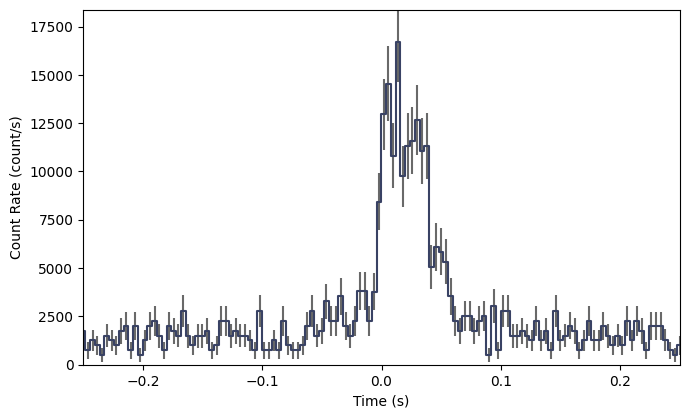

In [62]:
erange = (8.0, 900.0) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.25, 0.25)

In [48]:
# Fit background
bkgd_times = [(-5.0, -1.0), (1.0, 5.0)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=1) #increase order to 2 when you have a large interval 

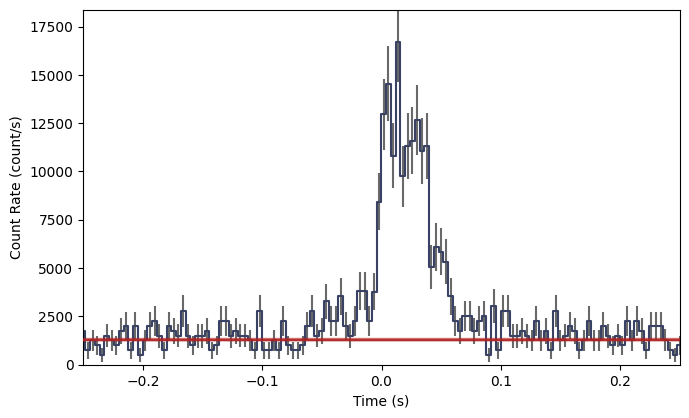

In [60]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.25, 0.25)
lcplot.xlim = view_range

In [49]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof

array([186.66467153,  44.84568409,  27.69770926,  26.23351976,
        16.66201409,  10.98426932,   9.73202632,   5.89492259,
         5.07799993,   4.54656296,   4.63903917,   5.18867549,
         4.64542231,   5.07639401,   4.79503937,   5.9136812 ,
         6.05804885,   6.20537934,   6.70701271,   5.95152255,
         6.83671072,   6.34540036,   7.98954565,   8.72056285,
        10.38400163,  11.00025124,  14.80827613,  19.94339406,
        17.81202232,  22.7425547 ,  23.19653616,  19.77535634,
        18.24541972,  23.35282125,  17.16061392,  27.61461755,
        23.55754733,  20.02840843,  19.1760478 ,  22.32887214,
        17.57912997,  27.87634373,  23.25516953,  30.27300157,
        26.57416546,  38.33407492,  33.00628672,  32.53602694,
        45.949754  ,  32.99568741,  46.79995267,  39.67394251,
        41.15194401,  50.61624833,  46.44152209,  40.55248929,
        46.78230718,  55.11618566,  45.66838251,  64.84637749,
        46.35236541,  55.39906246,  50.22716392,  49.25

In [50]:
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

Normalised residuals: mean= -5.83e-05  std= 1.02
NormaltestResult(statistic=76.65503664245175, pvalue=2.262404667229205e-17)


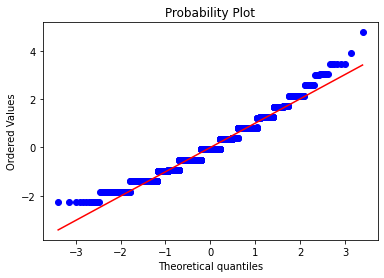

In [55]:
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [77]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection

src_time = (-0.004, 0.06) #should be 64ms
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

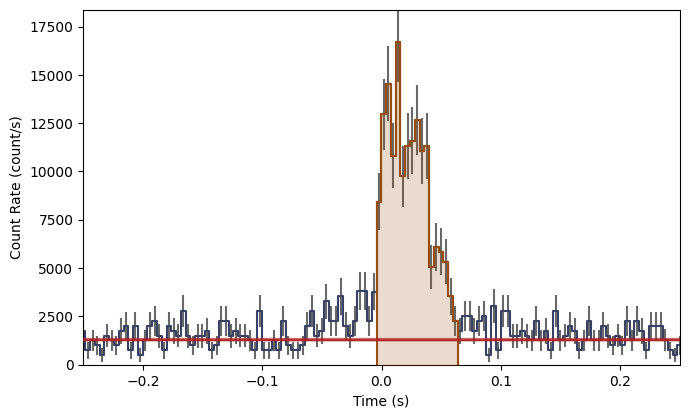

In [78]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

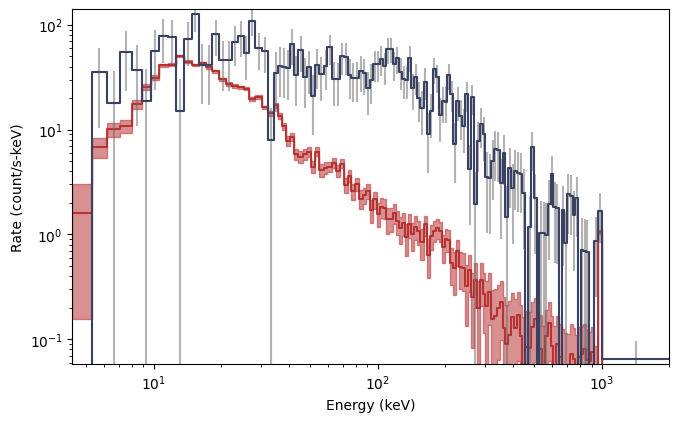

In [79]:
# The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection  to see what the background model looks like in comparison to the data:
# the observed count spectrum during the source selection
spec_data = tte.to_spectrum(time_range=src_time)
#spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
#spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)
specplot = Spectrum(data=spec_data, background=spec_bkgd)
#specplot.add_selection(spec_selection)

In [80]:
# Extract the corresponding PHA from source and bkg files
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

In [81]:
# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = 'GRB201227A_'+unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
# fparkey GRB201227A_n7.rsp GRB201227A_n7.pha+2 RESPFILE


In [83]:
# Time intervals for spectra
# Add time shift due to GBM vs. KW reference times

#fn_spec_times = '/home/guidorzi/ASIM/KW_LCs/GRB201227A_sp.txt'
#spec_times = np.loadtxt(fn_spec_times, unpack=True) + tshift
